This notebooks is divided in two parts:

1) Data visualization

2) Forecast experiments

## 1) DATA VISUALIZATION

In [17]:
import pandas as pd
import plotly as py
import numpy as np
pd.options.plotting.backend = 'plotly'

In [18]:
real_final_table = pd.read_csv('../data/forecasting.csv', parse_dates=['month'], index_col='month')
real_final_table.replace(0.0, np.nan, inplace=True)
real_final_table.fillna(method="bfill", axis=0, inplace=True)
real_final_table.head()

,Burger King,CVS Pharmacy,Chick-fil-A,Domino's Pizza,Dunkin',Enterprise Rent-A-Car,Great Clips,Jimmy John's,KFC,McDonald's,Papa John's Pizza,Pizza Hut,Starbucks,Subway,Taco Bell,The UPS Store,US Post Office,Walgreens,Wawa,Wendy's
month,,,,,,,,,,,,,,,,,,,,
2005-03-01,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2005-07-01,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2005-11-01,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2005-12-01,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2006-01-01,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [19]:
real_final_table['2010':].iloc[:, 0:5].plot(title = 'Total Review/Tips/Checkins Counts on Yelp for Top Brands')

In [20]:
real_final_table['2010':].iloc[:, 5:10].plot(title = 'Total Review/Tips/Checkins Counts on Yelp for Top Brands')

In [21]:
real_final_table['2010':].iloc[:, 10:15].plot(title = 'Total Review/Tips/Checkins Counts on Yelp for Top Brands')

In [22]:
real_final_table['2010':].iloc[:, 15:20].plot(title = 'Total Review/Tips/Checkins Counts on Yelp for Top Brands')

## 2) FORECASTING 

We will use the DARTS library makes it easier to handle time series experiments with multiple algorithms. 

Algorithms utilized will be ARIMA, PROPHET, NAIVE DRIFT and EXPONENTIAL SMOOTHING with the necesary trending and seasonality adjustements when needed. 

We will loop over the 20 brands and make and univariate forecasting with the 4 algorithms and save the metrics. 

Model selection will be done with Mean Absolute Percentage Error (MAPE). 

In [23]:
import pmdarima as pmd
import statsmodels.api as sm 
from scipy.stats import normaltest
import time
from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta
)
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox

import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

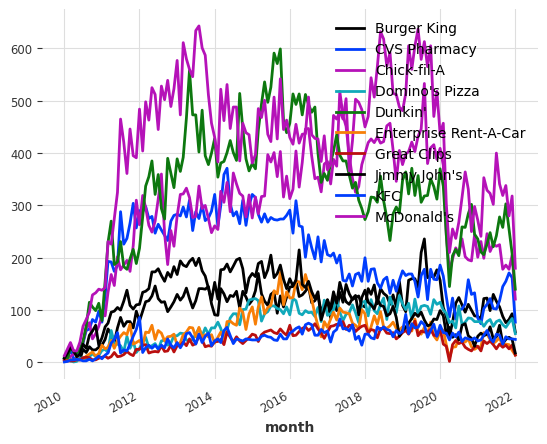

In [24]:
series = TimeSeries.from_dataframe(real_final_table['2010':], freq='MS')#, fillna_value=0, fill_missing_dates=True,)
series.plot()

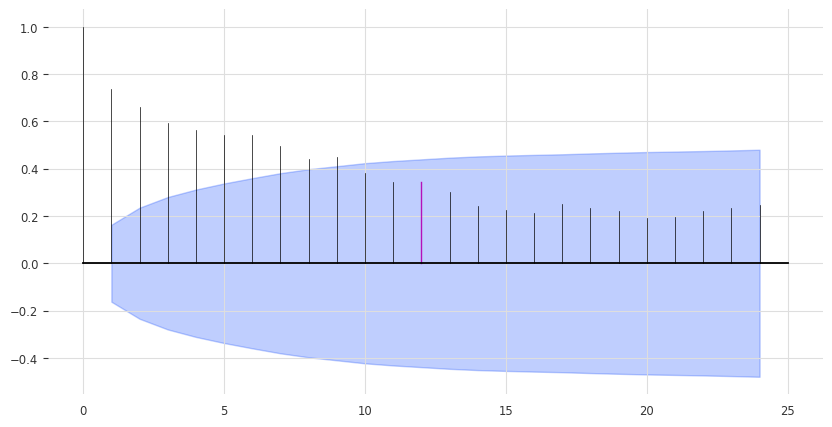

In [26]:
from darts.utils.statistics import check_seasonality, plot_acf

plot_acf(series['KFC'], m=12, alpha=0.05)

In [27]:
real_final_table.columns

Index(['Burger King', 'CVS Pharmacy', 'Chick-fil-A', 'Domino's Pizza',
       'Dunkin'', 'Enterprise Rent-A-Car', 'Great Clips', 'Jimmy John's',
       'KFC', 'McDonald's', 'Papa John's Pizza', 'Pizza Hut', 'Starbucks',
       'Subway', 'Taco Bell', 'The UPS Store', 'US Post Office', 'Walgreens',
       'Wawa', 'Wendy's'],
      dtype='object')

In [28]:
def prepare_arima(i,is_seasonal, mseas):
    y = np.asarray(series[i].pd_series())
    # get order of first differencing: the higher of KPSS and ADF test results
    n_kpss = pmd.arima.ndiffs(y, alpha=0.05, test='kpss', max_d=2)
    n_adf = pmd.arima.ndiffs(y, alpha=0.05, test='adf', max_d=2)
    n_diff = max(n_adf, n_kpss)

    # get order of seasonal differencing: the higher of OCSB and CH test results
    n_ocsb = pmd.arima.OCSBTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y)
    n_ch = pmd.arima.CHTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y)
    ns_diff = max(n_ocsb, n_ch, is_seasonal * 1)

    # set up the ARIMA forecaster
    m_arima = AutoARIMA(
        start_p=1, d=n_diff, start_q=1,
        max_p=4, max_d=n_diff, max_q=4,
        start_P=0, D=ns_diff, start_Q=0, m=max(4,mseas), seasonal=is_seasonal,
        max_P=3, max_D=1, max_Q=3,
        max_order=5,                       # p+q+p+Q <= max_order
        stationary=False, 
        information_criterion="bic", alpha=0.05, 
        test="kpss", seasonal_test="ocsb",
        stepwise=True, 
        suppress_warnings=True, error_action="trace", trace=True, with_intercept="auto")
    
    return m_arima


In [29]:
def prepare_theta(howmuch = 1):

    # prepare Theta forecaster

    # search space for best theta value: check 100 alternatives
    thetas = 2 - np.linspace(-10, 10, 100)

    # initialize search
    best_mape = float('inf')
    best_theta = 0
    # search for best theta among 50 values, as measured by MAPE
    for theta in thetas:
        model = Theta(theta)
        res = model.fit(train)
        pred_theta = model.predict(len(val)*howmuch)
        res_mape = mape(val, pred_theta)

        if res_mape < best_mape:
            best_mape = res_mape
            best_theta = theta

    m_theta = Theta(best_theta)   # best theta model among 100

    return m_theta

In [30]:
def prepare_exp(is_seasonal, mseas):
    if is_seasonal:
        m_expon = ExponentialSmoothing(seasonal_periods=mseas)
        return m_expon
    else:
        m_expon = ExponentialSmoothing()
        return m_expon

In [31]:
def eval_model(model, train, val, is_seasonal, mseas, howmuch = 1):
    t_start =  time.perf_counter()
    print("beginning: " + str(model))
    model.fit(train)
    
    if model == m_naive:
        if is_seasonal:
            forecast = model.predict(len(val)*howmuch)
            fc_drift = forecast
            modelS = NaiveSeasonal(K=mseas)
            modelS.fit(train)
            fc_seas = modelS.predict(len(val)*howmuch)
            forecast = fc_drift + fc_seas - train.last_value()
        else:
            forecast = model.predict(len(val)*howmuch)
    else:
        forecast = model.predict(len(val)*howmuch)
        
    res_mape = mape(val, forecast)
    res_mae = mae(val, forecast)
    res_r2 = r2_score(val, forecast)
    res_rmse = rmse(val, forecast)
    res_rmsle = rmsle(val, forecast)
    res_time = time.perf_counter() - t_start
    res_accuracy = {"MAPE":res_mape, "MAE":res_mae, "R squared":-res_r2, "RMSE":res_rmse, "RMSLE":res_rmsle, "time":res_time}

    results = [forecast, res_accuracy]
    print("completed: " + str(model) + ":" + str(res_time) + "sec")

    train_df = train.pd_dataframe()
    fig1 = px.line(train_df)
    fig1.update_layout(title='Actual')
    fig1.update_traces(line_color='purple', name='Actual')

    forecast_df = forecast.pd_dataframe()
    fig2 = px.line(forecast_df)
    fig2.update_layout(title='Forecast')
    fig2.update_traces(line_color='seagreen', name='Forecast')

    fig = go.Figure(data = fig1.data + fig2.data)
    return fig, results, train_df, forecast_df

In [32]:
df_full = []
for i in real_final_table.columns.tolist():
    train, val = series[i].split_after(pd.Timestamp('2021-01-01'))

    for m in range(2, 25):
        is_seasonal, mseas = check_seasonality(train, m=m, alpha=0.05)
        if is_seasonal:
            break

    m_exp = prepare_exp(is_seasonal, mseas)
    m_prophet = Prophet()
    #m_theta = prepare_theta()
    m_naive = NaiveDrift()
    m_arima = prepare_arima(i, is_seasonal, mseas)

    models = [ 
        m_exp, 
        #m_theta, 
        m_arima,
        m_naive, 
        m_prophet]
    df = pd.DataFrame(columns=['MAPE', 'MAE', 'R squared', 'RMSE', 'RMSLE', 'time'])
    for model in models:
        fig, results, train_df, forecast_df= eval_model(model, train, val, is_seasonal, mseas)
        fig.update_layout(title=i)
        #iplot(fig)
        df = df.append(results[1], ignore_index=True)
    df.index = ['Exponential Smoothing', 'ARIMA', 'Naive Drift', 'Prophet'] #'Theta',
    df = df.sort_values(by=['MAPE'])
    df_full.append(df)

beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=None
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12:0.2776656659999617sec
beginning: Auto-ARIMA
Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=1196.754, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=1205.434, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=1200.458, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=1194.595, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=1200.650, Time=0.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=1196.848, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=1201.597, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=1190.072, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=1192.494, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : BIC=1192.497, Time=0.01 s

In [33]:
df_mapes = pd.DataFrame()
for i in range(len(df_full)):
    df = df_full[i]
    df = pd.DataFrame(df['MAPE'])
    df.rename(columns={'MAPE': real_final_table.columns[i]}, inplace=True)
    df_mapes = pd.concat([df_mapes, df], axis=1)

In [34]:
df_mapes

,Burger King,CVS Pharmacy,Chick-fil-A,Domino's Pizza,Dunkin',Enterprise Rent-A-Car,Great Clips,Jimmy John's,KFC,McDonald's,Papa John's Pizza,Pizza Hut,Starbucks,Subway,Taco Bell,The UPS Store,US Post Office,Walgreens,Wawa,Wendy's
Exponential Smoothing,17.838592,33.696024,10.871184,11.066826,17.042250,28.072578,33.453235,25.242153,12.659442,14.256331,17.380799,22.658021,12.117219,38.282225,13.446858,31.051552,79.239832,35.862636,19.422167,14.978141
ARIMA,19.052243,24.755933,14.219634,10.980005,14.984037,68.370073,24.751535,32.601189,14.224230,18.378164,20.205877,24.120919,58.025699,43.571005,12.220714,28.992001,73.117652,23.664640,14.752420,15.433547
Naive Drift,20.289124,27.042499,16.328827,11.866586,15.607640,56.195256,26.396028,32.133509,19.986106,18.040973,23.569752,52.408975,16.098135,12.913805,19.001103,32.171192,69.696210,20.130352,30.791888,16.608834
Prophet,38.991712,29.331863,48.791133,33.113186,14.737681,23.610448,27.184225,24.811538,34.864133,46.713828,25.239979,20.254751,32.328089,19.546900,22.730971,20.317525,18.793536,58.832110,14.340149,16.083677


In [35]:
df_mapes.T

,Exponential Smoothing,ARIMA,Naive Drift,Prophet
Burger King,17.838592,19.052243,20.289124,38.991712
CVS Pharmacy,33.696024,24.755933,27.042499,29.331863
Chick-fil-A,10.871184,14.219634,16.328827,48.791133
Domino's Pizza,11.066826,10.980005,11.866586,33.113186
Dunkin',17.042250,14.984037,15.607640,14.737681
Enterprise Rent-A-Car,28.072578,68.370073,56.195256,23.610448
Great Clips,33.453235,24.751535,26.396028,27.184225
Jimmy John's,25.242153,32.601189,32.133509,24.811538
KFC,12.659442,14.224230,19.986106,34.864133
McDonald's,14.256331,18.378164,18.040973,46.713828


## SELECTED MODELS for each BRAND

In [39]:
mins = df_mapes.idxmin(axis="rows")

print(mins)

#mins = mins.tolist()

Burger King              Exponential Smoothing
CVS Pharmacy                             ARIMA
Chick-fil-A              Exponential Smoothing
Domino's Pizza                           ARIMA
Dunkin'                                Prophet
Enterprise Rent-A-Car                  Prophet
Great Clips                              ARIMA
Jimmy John's                           Prophet
KFC                      Exponential Smoothing
McDonald's               Exponential Smoothing
Papa John's Pizza        Exponential Smoothing
Pizza Hut                              Prophet
Starbucks                Exponential Smoothing
Subway                             Naive Drift
Taco Bell                                ARIMA
The UPS Store                          Prophet
US Post Office                         Prophet
Walgreens                          Naive Drift
Wawa                                   Prophet
Wendy's                  Exponential Smoothing
dtype: object


In [47]:
pd.DataFrame(mins, index=mins.index, columns=['Best Model']).to_csv('./data/model_for_each_ts.csv')

## RUNNING THE GRAPHICS for EACH MODEL
### and saving train/forest data to Pandas

In [ ]:
df_train_all= pd.DataFrame()
df_forecast_all= pd.DataFrame()
for j,i in enumerate(real_final_table.columns.tolist()):
    train, val = series[i].split_after(pd.Timestamp('2021-10-01'))


    howmuch = 7

    for m in range(2, 25):
        is_seasonal, mseas = check_seasonality(train, m=m, alpha=0.05)
        if is_seasonal:
            break

    m_exp = prepare_exp(is_seasonal, mseas)
    m_prophet = Prophet()
    m_theta = prepare_theta(howmuch)
    m_naive = NaiveDrift()
    m_arima = prepare_arima(i, is_seasonal, mseas)

    if mins[j] == 'Exponential Smoothing':
        model = m_exp
    elif mins[j] == 'Theta':
        model = m_theta
    elif mins[j] == 'ARIMA':
        model = m_arima
    elif mins[j] == 'Prophet':
        model = m_prophet
    elif mins[j] == 'Naive Drift':
        model = m_naive
    

    fig, results, train_df, forecast_df = eval_model(model, train, val, is_seasonal, mseas, howmuch)
    fig.update_layout(title=i)
    print('*************', str(mins[j]), '*************')
    iplot(fig)
    print(results[1])
    df_train_all = pd.concat([df_train_all, train_df], axis=1)
    df_forecast_all = pd.concat([df_forecast_all, forecast_df], axis=1)

beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=None
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12:0.053315291999751935sec
************* Exponential Smoothing *************


{'MAPE': 17.31244866418776, 'MAE': 12.026606784837247, 'R squared': -0.1935392180539498, 'RMSE': 13.12342106016021, 'RMSLE': 0.18138309080181425, 'time': 0.053315291999751935}
beginning: Auto-ARIMA
Performing stepwise search to minimize bic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : BIC=1501.320, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : BIC=1429.054, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : BIC=1496.379, Time=0.00 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : BIC=1406.302, Time=0.02 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : BIC=1382.768, Time=0.03 sec
 ARIMA(4,2,0)(0,0,0)[0] intercept   : BIC=1374.413, Time=0.04 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : BIC=1357.792, Time=0.14 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : BIC=1353.077, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.04 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : BIC=1357.9

{'MAPE': 38.67593872993136, 'MAE': 38.05255784003929, 'R squared': 0.0701785866702136, 'RMSE': 43.81123999111363, 'RMSLE': 0.3829411730318156, 'time': 1.0450127080002858}
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=None
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12:0.04727412499960337sec
************* Exponential Smoothing *************


{'MAPE': 20.43782266631775, 'MAE': 28.43061717146705, 'R squared': -0.044528417125788144, 'RMSE': 34.22584053903985, 'RMSLE': 0.22572248381064913, 'time': 0.04727412499960337}
beginning: Auto-ARIMA
Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,1,0)[16]             : BIC=1117.214, Time=0.03 sec
 ARIMA(0,1,0)(0,1,0)[16]             : BIC=1158.738, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[16]             : BIC=1112.112, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[16]             : BIC=1066.989, Time=0.24 sec
 ARIMA(0,1,1)(0,1,0)[16]             : BIC=1112.387, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[16]             : BIC=1071.813, Time=0.38 sec
 ARIMA(0,1,1)(0,1,2)[16]             : BIC=1071.811, Time=0.57 sec
 ARIMA(0,1,1)(1,1,0)[16]             : BIC=1090.649, Time=0.12 sec
 ARIMA(0,1,1)(1,1,2)[16]             : BIC=inf, Time=1.40 sec
 ARIMA(0,1,0)(0,1,1)[16]             : BIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,1,1)[16]             : BIC=1071.268, Time=0.29 sec
 ARIMA(0,1,2)(0,1,1)[16]        

{'MAPE': 19.084699222096603, 'MAE': 12.16788483503447, 'R squared': 0.49218860102728024, 'RMSE': 14.938711297173601, 'RMSLE': 0.2161650260861997, 'time': 5.226616292000472}
beginning: Prophet
completed: Prophet:0.5310348749990226sec
************* Prophet *************


{'MAPE': 22.674191793246955, 'MAE': 43.39606586661148, 'R squared': -0.0812836829319109, 'RMSE': 44.88477251518084, 'RMSLE': 0.23157676464590707, 'time': 0.5310348749990226}
beginning: Prophet
completed: Prophet:0.3611297919997014sec
************* Prophet *************


{'MAPE': 38.67222056084167, 'MAE': 9.316565617526962, 'R squared': 0.9815086259057302, 'RMSE': 11.512641326410865, 'RMSLE': 0.49110063592826037, 'time': 0.3611297919997014}
beginning: Auto-ARIMA
Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=1018.262, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=1043.004, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=1028.809, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=1015.045, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=1038.122, Time=0.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=1018.101, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=1022.189, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=1010.564, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=1013.900, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : BIC=1013.737, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=1023.994, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0]             

{'MAPE': 51.6553296934645, 'MAE': 8.345367715598629, 'R squared': 0.9638880238135552, 'RMSE': 10.99491784210985, 'RMSLE': 0.4707888191090301, 'time': 0.16647470900170447}
beginning: Prophet
completed: Prophet:0.3837424169996666sec
************* Prophet *************


{'MAPE': 58.09905891825675, 'MAE': 21.065753573037252, 'R squared': 1.8094580106938354, 'RMSE': 22.29264241608923, 'RMSLE': 0.7126093617327135, 'time': 0.3837424169996666}
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=6:0.04698445900066872sec
************* Exponential Smoothing *************


{'MAPE': 11.300524273843896, 'MAE': 5.039722747319959, 'R squared': 127.15437764714596, 'RMSE': 5.336548565154698, 'RMSLE': 0.11002942024294564, 'time': 0.04698445900066872}
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=None
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12:0.04822716600028798sec
************* Exponential Smoothing *************


{'MAPE': 22.097702094709618, 'MAE': 44.76249339407527, 'R squared': 0.019568322956746487, 'RMSE': 58.76941667823995, 'RMSLE': 0.2552293296313581, 'time': 0.04822716600028798}
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=3:0.04513529100040614sec
************* Exponential Smoothing *************


{'MAPE': 28.75427453754436, 'MAE': 9.138737576078436, 'R squared': 4.061619165008393, 'RMSE': 10.117172903487347, 'RMSLE': 0.26860955021582417, 'time': 0.04513529100040614}
beginning: Prophet
completed: Prophet:0.38252825000017765sec
************* Prophet *************


{'MAPE': 42.639759482447545, 'MAE': 12.041499498991044, 'R squared': 0.5333528685205962, 'RMSE': 12.56045273533859, 'RMSLE': 0.3661476577371232, 'time': 0.38252825000017765}
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=None
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12:0.04406504200051131sec
************* Exponential Smoothing *************


{'MAPE': 19.15260494840564, 'MAE': 85.57266951147805, 'R squared': -0.4560472407687238, 'RMSE': 92.33195696965045, 'RMSLE': 0.20303977961097047, 'time': 0.04406504200051131}
beginning: Naive drift model
completed: Naive drift model:0.014891291999447276sec
************* Naive Drift *************


{'MAPE': 13.955589731712328, 'MAE': 5.87470449172577, 'R squared': 1.2082332184188238, 'RMSE': 6.682468321014207, 'RMSLE': 0.14377497311508997, 'time': 0.014891291999447276}
beginning: Auto-ARIMA
Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=1341.470, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=1365.537, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=1337.164, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=1338.653, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=1360.733, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : BIC=1341.697, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : BIC=1345.287, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=1332.595, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0]             : BIC=1337.175, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=1336.984, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=1334.318, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]            

{'MAPE': 21.474355021877678, 'MAE': 22.015629021688436, 'R squared': 0.7610502320099044, 'RMSE': 27.67419698340509, 'RMSLE': 0.23523417362666518, 'time': 0.2209457079989079}
beginning: Prophet
completed: Prophet:0.3858877919992665sec
************* Prophet *************


{'MAPE': 31.648354743050543, 'MAE': 23.495053263107902, 'R squared': 0.7905226736465603, 'RMSE': 28.08956493409817, 'RMSLE': 0.3123448625000437, 'time': 0.3858877919992665}
beginning: Prophet
completed: Prophet:0.5182354589996976sec
************* Prophet *************


{'MAPE': 45.9504836614878, 'MAE': 20.204105705317257, 'R squared': 0.5363870200216543, 'RMSE': 20.542499884368528, 'RMSLE': 0.4201964918700727, 'time': 0.5182354589996976}
beginning: Naive drift model
completed: Naive drift model:0.015925249999781954sec
************* Naive Drift *************


{'MAPE': 40.251407386197705, 'MAE': 35.326241134751776, 'R squared': 0.9326788530341201, 'RMSE': 52.1034505789069, 'RMSLE': 0.4279057218804685, 'time': 0.015925249999781954}
beginning: Prophet
completed: Prophet:0.37177204199906555sec
************* Prophet *************


{'MAPE': 18.43396691739341, 'MAE': 18.591065391256915, 'R squared': -0.5185489862866164, 'RMSE': 22.45051707201492, 'RMSLE': 0.21277203122749996, 'time': 0.37177204199906555}
beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=None
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12:0.04898424999919371sec
************* Exponential Smoothing *************


{'MAPE': 27.56408961871908, 'MAE': 28.829076181341303, 'R squared': 0.13460704601043605, 'RMSE': 31.13208236196265, 'RMSLE': 0.2837977177432587, 'time': 0.04898424999919371}


In [ ]:
df_full

[                            MAPE        MAE  R squared       RMSE     RMSLE  \
 Exponential Smoothing  17.838592  15.696154  -0.132071  19.654377  0.213658   
 ARIMA                  19.052243  18.448566   0.118905  22.315871  0.231311   
 Naive Drift            20.289124  19.310606   0.217051  23.274031  0.243423   
 Prophet                38.991712  32.383915   2.060540  36.907645  0.363725   
 
                            time  
 Exponential Smoothing  0.051516  
 ARIMA                  0.217381  
 Naive Drift            0.015203  
 Prophet                0.582771  ,
                             MAPE        MAE  R squared       RMSE     RMSLE  \
 ARIMA                  24.755933  33.698329   1.194702  45.198978  0.387059   
 Naive Drift            27.042499  35.888889   1.000076  43.148336  0.365603   
 Prophet                29.331863  40.193222   1.780933  50.878711  0.465528   
 Exponential Smoothing  33.696024  45.323247   2.470227  56.835507  0.545145   
 
                    

In [ ]:
df_train_all

component,Burger King,CVS Pharmacy,Chick-fil-A,Domino's Pizza,Dunkin',Enterprise Rent-A-Car,Great Clips,Jimmy John's,KFC,McDonald's,Papa John's Pizza,Pizza Hut,Starbucks,Subway,Taco Bell,The UPS Store,US Post Office,Walgreens,Wawa,Wendy's
month,,,,,,,,,,,,,,,,,,,,
2010-01-01,7.0,8.0,5.0,8.0,9.0,5.0,4.0,8.0,1.0,13.0,1.0,2.0,49.0,5.0,8.0,2.0,3.0,3.0,15.0,4.0
2010-02-01,6.0,8.0,13.0,4.0,5.0,3.0,3.0,18.0,2.0,26.0,1.0,4.0,97.0,6.0,6.0,1.0,6.0,7.0,18.0,5.0
2010-03-01,3.0,26.0,11.0,3.0,31.0,6.0,3.0,29.0,5.0,38.0,2.0,3.0,96.0,6.0,8.0,3.0,12.0,14.0,14.0,6.0
2010-04-01,5.0,7.0,16.0,1.0,20.0,3.0,3.0,22.0,5.0,22.0,3.0,5.0,121.0,13.0,9.0,1.0,7.0,9.0,16.0,7.0
2010-05-01,6.0,8.0,19.0,2.0,18.0,8.0,5.0,11.0,6.0,22.0,1.0,6.0,114.0,11.0,13.0,2.0,7.0,8.0,27.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,130.0,103.0,226.0,69.0,221.0,36.0,34.0,45.0,39.0,302.0,37.0,46.0,646.0,52.0,144.0,88.0,44.0,88.0,144.0,132.0
2021-07-01,117.0,102.0,222.0,78.0,242.0,41.0,26.0,49.0,54.0,400.0,34.0,42.0,605.0,58.0,117.0,85.0,60.0,128.0,146.0,150.0
2021-08-01,106.0,118.0,225.0,81.0,278.0,47.0,35.0,71.0,52.0,341.0,50.0,36.0,624.0,63.0,163.0,95.0,46.0,156.0,150.0,142.0


In [ ]:
df_forecast_all

component,Burger King,CVS Pharmacy,Chick-fil-A,Domino's Pizza,Dunkin',Enterprise Rent-A-Car,Great Clips,Jimmy John's,KFC,McDonald's,Papa John's Pizza,Pizza Hut,Starbucks,Subway,Taco Bell,The UPS Store,US Post Office,Walgreens,Wawa,Wendy's
month,,,,,,,,,,,,,,,,,,,,
2021-11-01,75.864905,142.960773,164.757912,75.199059,197.129422,15.578562,32.036103,20.133126,51.534888,290.703399,44.268457,37.350725,557.710737,49.312057,137.898622,96.604722,38.688135,168.163121,115.581197,111.355110
2021-12-01,81.944899,144.079219,188.253181,70.118021,179.149170,25.226463,32.036103,19.618969,47.576541,292.335911,42.337943,39.481085,563.176901,49.624113,139.767655,125.288437,87.907917,169.326241,140.943347,113.780058
2022-01-01,76.889624,145.197666,176.302944,76.820734,184.466790,21.301797,32.036103,28.949356,50.007739,277.919992,43.809812,42.254859,490.605646,49.936170,138.915921,112.592001,56.392536,170.489362,99.411047,115.622396
2022-02-01,74.263927,146.316112,182.801856,71.796165,182.822961,14.833159,32.036103,25.039393,47.342351,262.786953,43.957709,35.183081,391.767510,50.248227,139.304064,98.507232,47.051287,171.652482,91.381972,109.763877
2022-03-01,94.995137,147.434559,179.305514,75.440241,194.380029,26.675421,32.036103,32.865803,44.798860,329.150495,42.027194,36.397098,465.846079,50.560284,139.127184,101.460580,48.911673,172.815603,115.784272,118.111603
2022-04-01,85.713607,148.553005,172.325334,74.713706,211.114764,25.215258,32.036103,35.436100,50.092011,294.228836,43.499064,26.776648,419.251757,50.872340,139.207789,95.701216,41.751634,173.978723,101.231994,111.849353
2022-05-01,81.434285,149.671451,183.162977,73.421209,206.351159,26.875297,32.036103,35.514522,53.448151,327.305437,43.646960,27.964851,512.770470,51.184397,139.171057,100.737426,28.261346,175.141844,93.798321,122.384186
2022-06-01,89.816001,150.789898,190.381518,74.666351,200.006728,26.495581,32.036103,30.671065,49.489805,317.741811,41.716446,29.073723,491.839500,51.496454,139.187796,97.215906,27.398770,176.304965,70.643191,116.639061
2022-07-01,102.097442,151.908344,191.491561,80.771782,194.530969,22.265744,32.036103,33.956082,51.921002,354.943443,43.188315,30.189474,427.583591,51.808511,139.180168,105.635072,35.786890,177.468085,107.710923,127.277964


In [ ]:
df_train_all.to_csv('./data/train_ts.csv')
df_forecast_all.to_csv('./data/forecast_ts.csv')

In [ ]:
import sqlalchemy
import pandas as pd

In [ ]:
engine = sqlalchemy.create_engine("mysql+pymysql://{user}:{pw}@{address}/{db}"
.format(user="root",
        address = '35.239.80.227:3306',
        pw="Henry12.BORIS99",
        db="yelp"))

In [ ]:
df_train_all.to_sql('forecasting_train', con=engine, if_exists='append', index=False)
df_forecast_all.to_sql('forecasting_val', con=engine, if_exists='append', index=False)

21